In [1]:
from __future__ import print_function
from bs4 import BeautifulSoup as bs
from colour import Color
from corextopic import corextopic as ct
from gensim.corpora import Dictionary
from gensim.models import doc2vec
from gensim.models.coherencemodel import CoherenceModel
from htmlparsing_kit import *
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.util import everygrams
from nordvpn_switcher import initialize_VPN,rotate_VPN,terminate_VPN
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from stop_words import get_stop_words
from string import digits
from tqdm import tqdm
from webscraping_kit import read_jsoncsv, read_htmlfile, read_htmlresponse, read_driverresponse, get_cases
from webscraping_kit import write_htmlfile, write_json_tofile, write_driverhtmlfile, rmnl
from htmlparsing_kit import clean_sections
import matplotlib.pyplot as plt
import multiprocessing as mp
from selenium import webdriver
import numpy as np
import pandas as pd
import re, os, glob, csv, math, requests, time, sys, random, json, datetime, urllib, nltk, pickle
import scipy.sparse as ss
from scipy import spatial
%matplotlib inline

In [2]:
def optimize_params(docs,ngramranges,maxdflist,maxfeatures,applicanttype):
    itercounter = 0
    results = []
    for nr in ngramranges:
        print('-------------------------------------------------')
        print("         Ngram range: "+ ','.join([str(x) for x in nr]))
        print('-------------------------------------------------')
        for mx in maxdflist:
            print('           -------------------------             ')
            print("             Max Document Frequency:             "+ str(mx))
            print('           -------------------------             ')
            for fc in maxfeatures:
                print("Max Features: "+str(fc))
                vectorizern = TfidfVectorizer(ngram_range=(nr[0], nr[1]), max_features = fc, max_df = mx, min_df = 0.01)
                dtm_tf = vectorizern.fit_transform(docs)
                dtm_tf = ss.csr_matrix(dtm_tf)
                words = vectorizern.get_feature_names_out()
                for T in T_list:
                    print("Topic count: "+str(T))
                    topic_model = ct.Corex(n_hidden=T)
                    topic_model.fit(dtm_tf, words=words, docs=docs)
                    topicstc = topic_model.tc
                    results.append(['_'.join([str(x) for x in nr]),mx,fc,T,topicstc])
                    itercounter +=1
                    print(topicstc)
            print(itercounter)
        print('--------------------------------------------------')
    rdf = pd.DataFrame(results,columns=['ngramrange','maxdf','maxfeatures','topiccount','totalcorrelation'])
    rdf['applicant'] = applicanttype
    return rdf

In [3]:
mainpath = str(os.getcwd())+'/'
df = pd.read_csv(mainpath+"output/5_model_results.csv",sep='\t')
print(df.shape)
df['cleansections']=df['sections'].apply(lambda x: clean_sections(x))
df['datetime'] = pd.to_datetime(df['date'])
df['year'] = df['datetime'].dt.year

(36461, 29)


In [4]:
df20 = df[df['year'].isin([2020,2021])]
print(df20.shape)

(17744, 32)


In [5]:
print(df20.shape[0]/df.shape[0])

0.48665697594690216


In [7]:
docs =df20['topiccleantext'].tolist()
print(len(docs))

17744


In [8]:
T_list = [5,10,15]
maxfeatures = [4000,5000,6000,7000] # 9000 for tt; <=8000 for ll
maxdflist = [0.75,0.8,0.85]
ngramranges = [[1,2],[1,3],[1,4]]
print(len(T_list)*len(maxfeatures)*len(maxdflist)*len(ngramranges))

108


In [1]:
# tsamp = random.sample(df20[df20['applicant']=='t']['text'].tolist(),1)[0][:1000]
# print(tsamp)

In [12]:
best = optimize_params(docs,ngramranges,maxdflist,maxfeatures,'both')

...

           -------------------------             
             Max Document Frequency:             0.85
           -------------------------             
Max Features: 4000
Topic count: 5
7.282368848948565
Topic count: 10
7.898891284823947
Topic count: 15
8.276628521189679
Max Features: 5000
Topic count: 5
7.327166634624435
Topic count: 10
8.326916574802095
Topic count: 15
8.321317523136997
Max Features: 6000
Topic count: 5
7.124895282239359
Topic count: 10
8.505733826888925
Topic count: 15
9.231217690743065
Max Features: 7000
Topic count: 5
7.386380809819233
Topic count: 10
8.106232218901157
Topic count: 15
9.236665514587955
108
--------------------------------------------------


In [14]:
best['bestparams'] = np.where(best['totalcorrelation']==best['totalcorrelation'].max(), 'best','other')
best[best['bestparams']=='best']

,ngramrange,maxdf,maxfeatures,topiccount,totalcorrelation,applicant,bestparams
83,1_4,0.75,7000,15,9.46888,both,best


In [15]:
best.to_csv(mainpath + 'output/6_corex_paramopt.csv',sep='\t',index=False,quoting=csv.QUOTE_ALL)

In [16]:
vectorizern = TfidfVectorizer(ngram_range=(1, 4), max_features = 7000, max_df = 0.75, min_df = 0.01)
dtm_tf = vectorizern.fit_transform(docs)
dtm_tf = ss.csr_matrix(dtm_tf)
words = vectorizern.get_feature_names_out()

In [17]:
topic_model = ct.Corex(n_hidden=15, seed=42)
topic_model.fit(dtm_tf, words=words, docs=docs)

In [18]:
print(topic_model.tc)
print(topic_model.tcs)

9.587443535882201
[2.28024341 1.78641696 1.11807564 0.87985093 0.61170204 0.56631875
 0.47127803 0.46385884 0.45680238 0.36077904 0.27823818 0.1746127
 0.08279911 0.04219068 0.01427684]


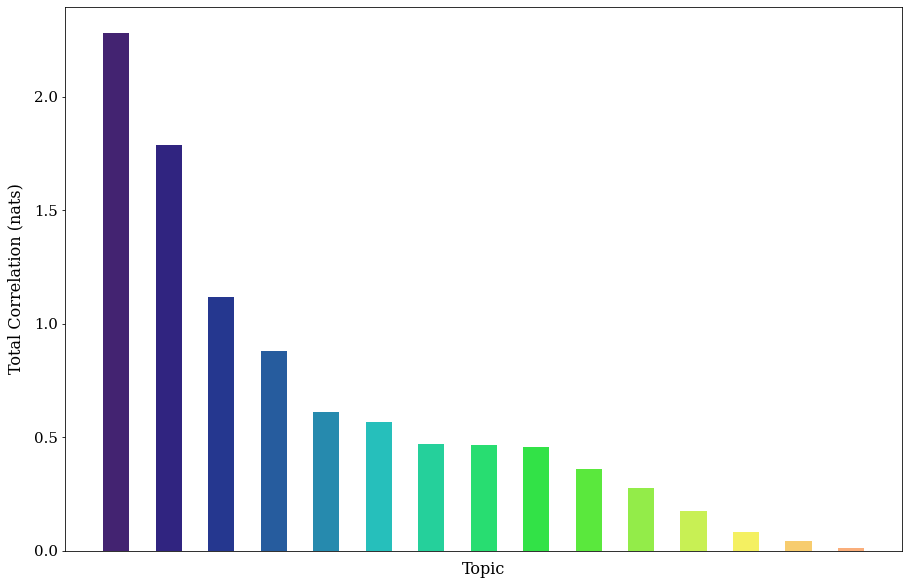

In [321]:
numt = 15
startcolor = Color("#432371")
endcolor = Color("#FAAE7B")
colors = [str(x) for x in list(startcolor.range_to(endcolor,numt))]
plt.figure(figsize=(15,10))
plt.bar(list(range(0,numt)), topic_model.tcs, color=colors, width=0.5)
plt.xticks([])

plt.xlabel('Topic', fontsize=16,labelpad=10)
plt.ylabel('Total Correlation (nats)', fontsize=16,labelpad=10)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 16
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.yticks(rotation = 0,fontsize=15,fontname='serif')
plt.xticks(rotation = 45,fontsize=15,fontname='serif')
plt.xlabel('Topic', fontsize=16,labelpad=10,fontname='serif')
plt.ylabel('Total Correlation (nats)', fontsize=16,labelpad=10,fontname='serif')
plt.savefig(mainpath + 'graphs/6_corextopics_tc.png', dpi=600, bbox_inches='tight')

In [20]:
topicstrings = []
topics = topic_model.get_topics()
for topic_n,topic in enumerate(topics):
    # w: word, mi: mutual information, s: sign
    topic = [(w,mi,s) if s > 0 else ('~'+w,mi,s) for w,mi,s in topic]
    words,mis,signs = zip(*topic)    
    topic_str = str(topic_n+1)+': '+', '.join(words)
    print(topic_str)
    # topicstrings.append(topic_str)

1: condition specify, specify, previous, condition, meet, request payment arrears rent, request payment arrears, request payment, previous application, pay rent arrears
2: make motion, subsection, make, void, motion, payment make, 7411, subsection 7411 act, subsection 7411, amount require subsection
3: tenant, tenant pay, tenant shall, rent tenant, rent deposit tenant, deposit tenant, owe tenant, unit tenant, tenant shall also pay, tenant shall also
4: damage, review, evidence, repair, another, testify, request review, residential, person, n12
5: condition set, 2041, arrears arrears, subject condition, relief eviction subject, eviction subject, eviction subject condition, unfair relief eviction subject, relief eviction subject condition, eviction subject condition set
6: regulation, emergency civil, civil tpaa, emergency civil tpaa, civil, tpaa, emergency, make emergency civil, make emergency civil tpaa, make emergency
7: ~deposit, section rtaa matter, ~serve notice, section rtaa, ~ren

In [320]:
topicdf = pd.DataFrame(topic_model.p_y_given_x)
topicdf.columns = list(range(0,numt))
topicdf['cid'] = df20['cid'].tolist()
topicdf.to_csv(mainpath + 'output/6_corextopics_vals.csv',sep='\t',index=False,quoting=csv.QUOTE_ALL)
del topicdf['cid']
topicdf = topicdf.idxmax(axis=1).reset_index()
del topicdf['index']
topicdf.columns = ['topic']
topicdf['cid'] = df20['cid'].tolist()
df20 = df20.copy()
df20['topic'] = df20['cid'].map(dict(zip(topicdf['cid'],topicdf['topic'])))

In [22]:
df20['topic'].value_counts()

1     6174
3     2545
0     2380
2     1648
14    1498
8     1016
4      711
6      402
7      334
5      267
9      255
13     175
11     120
10     112
12     107
Name: topic, dtype: int64

In [318]:
tnamedict = {0:"Failed Meet Condition",1:"Evict Nonpayment",2:"Evict Nonpayment",3:"Breaking Rules",4:"Evict Nonpayment",5:"Agree Terminate",6:"Evict Nonpayment/Agree Terminate", 7:"Evict Nonpayment/Agree Terminate",8:"Agree Terminate",9:"Evict Nonpayment and NSF Charges",10:"Eviction Moratorium",11:"Rent Changes",12:"Evict Nonpayment",13:"Failed Meet Condition",14:"Evict Nonpayment"}

In [2]:
# tsamp = random.sample(df20[df20['topic']==4]['text'].tolist(),1)[0][:1000]
# print(tsamp)

In [319]:
df20['tname'] = df20['topic'].map(tnamedict)

In [323]:
df20['tname'].value_counts()

Evict Nonpayment                    10138
Failed Meet Condition                2555
Breaking Rules                       2545
Agree Terminate                      1283
Evict Nonpayment/Agree Terminate      736
Evict Nonpayment and NSF Charges      255
Rent Changes                          120
Eviction Moratorium                   112
Name: tname, dtype: int64

In [322]:
df20.to_csv(mainpath + 'output/6_case_db_202021.csv',sep='\t',index=False,quoting=csv.QUOTE_ALL)
